In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from tqdm.notebook import tqdm_notebook as tqdm
import cv2
import skimage
from skimage.transform import resize
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.optimizers import Adam

In [2]:
SIZE_X = 128 
SIZE_Y = 128
n_classes=4 #Number of classes for segmentation

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
train_DF = pd.read_pickle(r"../../../Datasets/Dataset_A/aug_train_DF_{}.pkl".format(SIZE_X))
val_DF = pd.read_pickle(r"../../../Datasets/Dataset_A/aug_val_DF_{}.pkl".format(SIZE_X))
test_DF = pd.read_pickle(r"../../../Datasets/Dataset_A/aug_test_DF_{}.pkl".format(SIZE_X))

In [5]:
def normalize(img):
    plt.imsave('DR.png', img, cmap='gray')
    return cv2.imread('DR.png')[:, :, 0]

In [6]:
train_DF["Images"] = train_DF["Images"].apply(normalize)
val_DF["Images"] = val_DF["Images"].apply(normalize)
test_DF["Images"] = test_DF["Images"].apply(normalize)

In [7]:
classes_dict = {"Not Tumor": 0, "Meningioma": 1, "Glioma": 2, "Pituitary": 3}
for index, row in train_DF.iterrows():
    row["Tumor Mask"] = row["Tumor Mask"] * classes_dict[row["Labels"]]
    
for index, row in val_DF.iterrows():
    row["Tumor Mask"] = row["Tumor Mask"] * classes_dict[row["Labels"]]
    
for index, row in test_DF.iterrows():
    row["Tumor Mask"] = row["Tumor Mask"] * classes_dict[row["Labels"]]

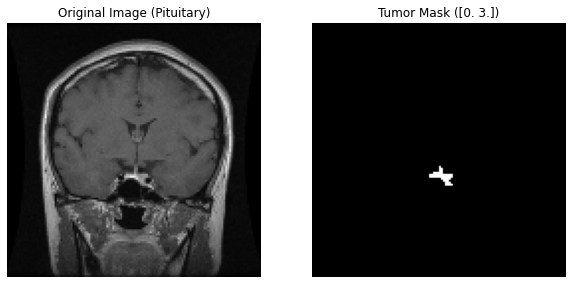

In [8]:
randInt = np.random.randint(0,len(train_DF))

# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 2

img  = train_DF.Images[randInt]
mask = train_DF["Tumor Mask"][randInt]


# Display Original Image
fig.add_subplot(rows, columns, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image ({})'.format(train_DF.Labels[randInt]))
plt.axis('off')
  
# Display Tumor Mask
fig.add_subplot(rows, columns, 2)
plt.imshow(mask, cmap='gray')
plt.title('Tumor Mask ({})'.format(np.unique(mask)))
plt.axis('off')
plt.show()

In [9]:
train_DF.head()

,PID,Images,Tumor Mask,Labels
0,101016,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Meningioma
1,100820,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Glioma
2,103670,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Pituitary
3,103671,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Pituitary
4,105374,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Meningioma


In [10]:
test_DF.head()

,PID,Images,Tumor Mask,Labels
0,106665,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Meningioma
1,108945,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Meningioma
2,MR051644C,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 3,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Glioma
3,106720,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Meningioma
4,97943,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",Meningioma


In [11]:
y_train = train_DF["Tumor Mask"].tolist()
X_train = train_DF['Images'].tolist()
y_train = np.array(y_train).reshape(-1, SIZE_X, SIZE_Y)
X_train = np.array(X_train).reshape(-1, SIZE_X, SIZE_Y)


y_val = val_DF["Tumor Mask"].tolist()
X_val = val_DF['Images'].tolist()
y_val = np.array(y_val).reshape(-1, SIZE_X, SIZE_Y)
X_val = np.array(X_val).reshape(-1, SIZE_X, SIZE_Y)

y_test = test_DF["Tumor Mask"].tolist()
X_test = test_DF['Images'].tolist()
y_test = np.array(y_test).reshape(-1, SIZE_X, SIZE_Y)
X_test = np.array(X_test).reshape(-1, SIZE_X, SIZE_Y)


print("X_train shape:", X_train.shape," | y_train shape:", y_train.shape)
print("X_val shape  :",X_val.shape," | y_test shape : ", y_val.shape)
print("X_test shape :",X_test.shape," | y_test shape : ", y_test.shape)

X_train shape: (9192, 128, 128)  | y_train shape: (9192, 128, 128)
X_val shape  : (1224, 128, 128)  | y_test shape :  (1224, 128, 128)
X_test shape : (1840, 128, 128)  | y_test shape :  (1840, 128, 128)


In [12]:
y_train = np.expand_dims(y_train, axis=3)
X_train = np.expand_dims(X_train, axis=3)
X_train = X_train/255

y_val = np.expand_dims(y_val, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_val = X_val/255

y_test = np.expand_dims(y_test, axis=3)
X_test = np.expand_dims(X_test, axis=3)
X_test = X_test/255

print("X_train shape:", X_train.shape," | y_train shape:", y_train.shape)
print("X_val shape  :",X_val.shape," | y_test shape : ", y_val.shape)
print("X_test shape :",X_test.shape," | y_test shape : ", y_test.shape)

X_train shape: (9192, 128, 128, 1)  | y_train shape: (9192, 128, 128, 1)
X_val shape  : (1224, 128, 128, 1)  | y_test shape :  (1224, 128, 128, 1)
X_test shape : (1840, 128, 128, 1)  | y_test shape :  (1840, 128, 128, 1)


In [13]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_val_cat = to_categorical(y_val, num_classes=n_classes)
y_test_cat = to_categorical(y_test, num_classes=n_classes)

In [14]:
print("X_train shape:", X_train.shape,"| y_train shape:", y_train_cat.shape)
print("X_val shape:  ", X_val.shape,"| y_train shape: ", y_val_cat.shape)
print("X_test shape :",X_test.shape,"| y_test shape : ", y_test_cat.shape)

X_train shape: (9192, 128, 128, 1) | y_train shape: (9192, 128, 128, 4)
X_val shape:   (1224, 128, 128, 1) | y_train shape:  (1224, 128, 128, 4)
X_test shape : (1840, 128, 128, 1) | y_test shape :  (1840, 128, 128, 4)


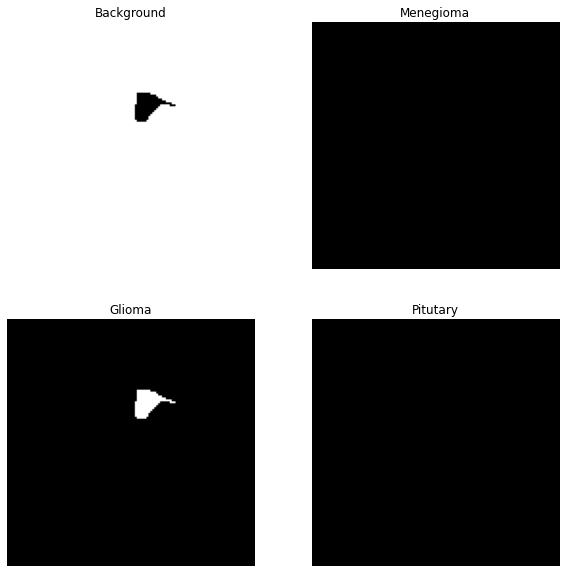

In [15]:
randInt = np.random.randint(len(y_test_cat))
mask = y_test_cat[randInt, :, :, :]
# create figure
fig = plt.figure(figsize=(10, 10))
  
# setting values to rows and column variables
rows = 2
columns = 2

images = []
titles = ["Background", "Menegioma", "Glioma", "Pitutary"]

# reading images
for i in range(4):
    images.append(mask[:, :, i])

  
# Adds a subplot at the 1st position
for i in range(4):
    fig.add_subplot(rows, columns, i+1)

    # showing image
    plt.imshow(images[i], 'gray')
    plt.axis('off')
    plt.title(titles[i])


In [16]:
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = labelencoder.fit_transform(y_train.reshape(-1,1).ravel()))
print("Class weights are...:", class_weights)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

Class weights are...: [ 0.2542887  60.19513552 24.58039623 98.36255525]


In [17]:
# np.save("class_weights.npy", class_weights)

In [18]:
import os
exp_num = []
if not os.path.exists("./experiments"):
    os.mkdir("./experiments")
folders = os.listdir("./experiments")
for folder in folders:
    exp_num.append(int(folder.split("#")[1]))


if len(exp_num) == 0:
    exp_path = r"./experiments/exp#1"
else:
    exp_path = r"./experiments/exp#"+str(max(exp_num)+1)




os.mkdir(exp_path)
os.mkdir(os.path.join(exp_path, "results"))
os.mkdir(os.path.join(exp_path, "weights"))

results = os.path.join(exp_path, "results")
weights = os.path.join(exp_path, "weights")

In [19]:
import segmentation_models as sm

activation='softmax'

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=class_weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)



metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

Segmentation Models: using `keras` framework.


In [20]:
sm.set_framework('tf.keras')
sm.framework()

# BACKBONE = ''
# preprocess_input = sm.get_preprocessing(BACKBONE)

# # preprocess input
# X_train = preprocess_input(X_train1)
# X_test = preprocess_input(X_test1)

# define model
model = sm.Linknet(input_shape=(SIZE_X, SIZE_Y, 1), classes=n_classes, activation=activation,  encoder_weights=None)

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics=metrics)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [21]:
from keras.callbacks import ModelCheckpoint



model_checkpoint_callback = ModelCheckpoint(
    filepath= os.path.join(weights, "best.h5"),
    verbose=100, 
    save_best_only=False, 
    mode='max')

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'loss val_accuracy', patience = 10)
    
history = model.fit(X_train, 
        y_train_cat, 
        batch_size = 16, 
        verbose=1, 
        epochs=80, 
        validation_data=(X_val, y_val_cat), 
        callbacks=[model_checkpoint_callback],
        shuffle=False)



Epoch 1/80
575/575 [==============================] - 130s 196ms/step - loss: -4.6356 - iou_score: 0.1810 - f1-score: 0.2581 - val_loss: -3.2999 - val_iou_score: 0.2368 - val_f1-score: 0.2969

Epoch 00001: saving model to ./experiments/exp#4\weights\best.h5


C:\Users\Ma7moud\anaconda3\envs\T-UNet\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/80
575/575 [==============================] - 39s 68ms/step - loss: -13.8860 - iou_score: 0.2905 - f1-score: 0.3912 - val_loss: -14.7628 - val_iou_score: 0.3516 - val_f1-score: 0.4340

Epoch 00002: saving model to ./experiments/exp#4\weights\best.h5
Epoch 3/80
575/575 [==============================] - 40s 69ms/step - loss: -18.3282 - iou_score: 0.4110 - f1-score: 0.5079 - val_loss: -20.3063 - val_iou_score: 0.4465 - val_f1-score: 0.5379

Epoch 00003: saving model to ./experiments/exp#4\weights\best.h5
Epoch 4/80
575/575 [==============================] - 39s 69ms/step - loss: -26.1559 - iou_score: 0.5350 - f1-score: 0.6432 - val_loss: -23.2094 - val_iou_score: 0.4871 - val_f1-score: 0.5887

Epoch 00004: saving model to ./experiments/exp#4\weights\best.h5
Epoch 5/80
575/575 [==============================] - 40s 69ms/step - loss: -29.5998 - iou_score: 0.5937 - f1-score: 0.6997 - val_loss: -28.0671 - val_iou_score: 0.5669 - val_f1-score: 0.6656

Epoch 00005: saving model to ./ex

575/575 [==============================] - 44s 77ms/step - loss: -40.7864 - iou_score: 0.8701 - f1-score: 0.9254 - val_loss: -36.1671 - val_iou_score: 0.7477 - val_f1-score: 0.8335

Epoch 00033: saving model to ./experiments/exp#4\weights\best.h5
Epoch 34/80
575/575 [==============================] - 40s 69ms/step - loss: -40.6690 - iou_score: 0.8660 - f1-score: 0.9227 - val_loss: -35.6881 - val_iou_score: 0.7322 - val_f1-score: 0.8191

Epoch 00034: saving model to ./experiments/exp#4\weights\best.h5
Epoch 35/80
575/575 [==============================] - 40s 69ms/step - loss: -40.7551 - iou_score: 0.8691 - f1-score: 0.9247 - val_loss: -36.4508 - val_iou_score: 0.7522 - val_f1-score: 0.8388

Epoch 00035: saving model to ./experiments/exp#4\weights\best.h5
Epoch 36/80
575/575 [==============================] - 40s 69ms/step - loss: -41.0586 - iou_score: 0.8791 - f1-score: 0.9311 - val_loss: -36.4328 - val_iou_score: 0.7619 - val_f1-score: 0.8456

Epoch 00036: saving model to ./experiment


Epoch 00064: saving model to ./experiments/exp#4\weights\best.h5
Epoch 65/80
575/575 [==============================] - 40s 69ms/step - loss: -41.6910 - iou_score: 0.8849 - f1-score: 0.9358 - val_loss: -37.3214 - val_iou_score: 0.7682 - val_f1-score: 0.8515

Epoch 00065: saving model to ./experiments/exp#4\weights\best.h5
Epoch 66/80
575/575 [==============================] - 40s 69ms/step - loss: -42.0244 - iou_score: 0.8975 - f1-score: 0.9435 - val_loss: -37.2781 - val_iou_score: 0.7684 - val_f1-score: 0.8514

Epoch 00066: saving model to ./experiments/exp#4\weights\best.h5
Epoch 67/80
575/575 [==============================] - 40s 69ms/step - loss: -41.5352 - iou_score: 0.8818 - f1-score: 0.9330 - val_loss: -37.5534 - val_iou_score: 0.7696 - val_f1-score: 0.8532

Epoch 00067: saving model to ./experiments/exp#4\weights\best.h5
Epoch 68/80
575/575 [==============================] - 40s 69ms/step - loss: -42.1034 - iou_score: 0.8984 - f1-score: 0.9439 - val_loss: -37.6814 - val_iou_s

In [22]:
# acc = model.evaluate(X_test, y_test_cat)
# name = str(round(acc, 4))

In [23]:
# Save The Trained model along with it training history   
metrics = pd.DataFrame(history.history)
metrics.to_pickle(os.path.join(results, "metrics"+'.pkl'))
model.save(os.path.join(weights, "First_Mulit_UNet" + '.h5'))

In [24]:
pd.DataFrame(history.history)

,loss,iou_score,f1-score,val_loss,val_iou_score,val_f1-score
0,-4.635561,0.180993,0.258075,-3.299887,0.236799,0.296913
1,-13.886029,0.290461,0.391170,-14.762849,0.351574,0.434016
2,-18.328199,0.410991,0.507894,-20.306297,0.446496,0.537920
3,-26.155865,0.535050,0.643244,-23.209364,0.487147,0.588659
4,-29.599825,0.593662,0.699701,-28.067146,0.566894,0.665606
...,...,...,...,...,...,...
75,-41.207825,0.871226,0.926316,-30.267115,0.605733,0.709279
76,-38.599247,0.797505,0.869925,-16.948536,0.432392,0.514500
77,-40.094452,0.836362,0.900515,-37.203876,0.762104,0.846564
78,-42.090004,0.896872,0.942829,-37.463234,0.770134,0.852339


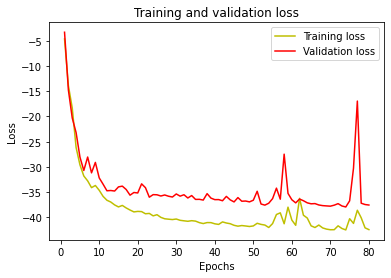

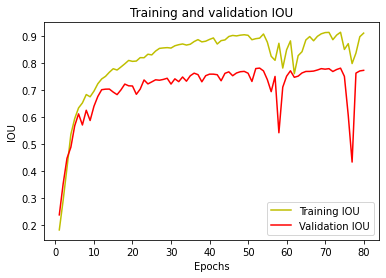

In [25]:
loss = metrics['loss']
val_loss = metrics['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(os.path.join(results, 'loss_epoch.png'))
plt.legend()

plt.show()

acc = metrics['iou_score']
val_acc = metrics['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.savefig(os.path.join(results, 'IoU.png'))
plt.show()

In [26]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

Mean IoU = 0.7773807
[[1.6777216e+07 8.2630000e+03 5.2771000e+04 9.5930000e+03]
 [1.1387000e+04 1.1108700e+05 1.2690000e+03 7.0300000e+02]
 [1.1400900e+05 4.8300000e+02 1.8891700e+05 0.0000000e+00]
 [1.1295000e+04 6.0000000e+01 0.0000000e+00 6.8394000e+04]]
IoU for class1 is:  0.9877936
IoU for class2 is:  0.833661
IoU for class3 is:  0.52851456
IoU for class4 is:  0.75955355


In [27]:
def prob_class(predicted_img, class_dic):
    rev_classes_dict = dict([(value, key) for key, value in class_dic.items()])
    result = ""
    if len(np.unique(predicted_img)) == 1:
        result = "(No Tumor)"
    else:
        for cls in np.unique(predicted_img):
            if cls != 0:
                prob = (predicted_img == cls).sum() / (0 != predicted_img).sum() 
                result += "({} {}%) ".format(rev_classes_dict[cls], str( round(prob*100, 2) ))

    return result

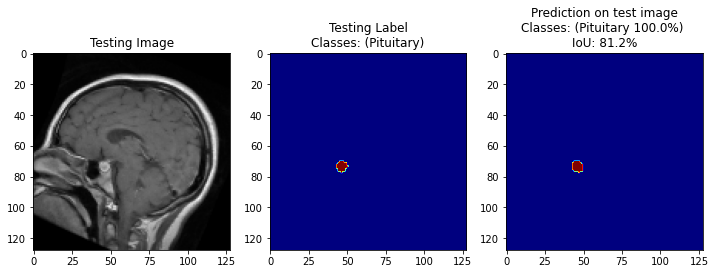

In [28]:
import random
test_img_number = random.randint(0, len(X_test))
rev_classes_dict = dict([(value, key) for key, value in classes_dict.items()])



test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]



intersection = np.logical_and(ground_truth[:,:,0], predicted_img)
union = np.logical_or(ground_truth[:,:,0], predicted_img)
iou_score = np.sum(intersection) / np.sum(union)

accuracy = str(round(iou_score * 100, 1))



plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')

plt.subplot(232)
plt.title('Testing Label\nClasses: ({})'.format(rev_classes_dict[np.unique(ground_truth)[1]]))
plt.imshow(ground_truth[:,:,0], cmap='jet')

plt.subplot(233)
plt.title('Prediction on test image\nClasses: {}\nIoU: {}%'.format(prob_class(predicted_img, classes_dict), accuracy))
plt.imshow(predicted_img, cmap='jet')
plt.savefig(os.path.join(results, 'loss_epoch.png'))
plt.show()